* https://www.gov.uk/guidance/mot-inspection-manual-for-private-passenger-and-light-commercial-vehicles
* https://www.data.gov.uk/dataset/e3939ef8-30c7-4ca8-9c7c-ad9475cc9b2f/anonymised-mot-tests-and-results
* https://www.gov.uk/government/news/mot-changes-20-may-2018

#### Data separator cleanup code

In [1]:
from dask.distributed import Client, wait
from distributed import progress
from glob import glob
from operator import itemgetter
import dask.dataframe as dd
import csv
import pandas as pd

In [2]:
import dask
dask.__version__

'2023.5.0'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.30 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39347,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.30 GiB
Comm: tcp://127.0.0.1:36893,Total threads: 3
Dashboard: http://127.0.0.1:35933/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:41131,


In [4]:
txt_files = glob('data/test_*.txt')
csv_files = glob('data/unzipped/**/*.csv', recursive=True)

files = txt_files + csv_files
len(files)

104

In [5]:
def sniff_dialect(file):
    with open(file) as csvfile:
        dialect = csv.Sniffer().sniff(csvfile.read(10000))
        dialect_info = dict(dialect.__dict__)
        dialect_info['file'] = file
    return dialect_info

In [6]:
dialects = [sniff_dialect(file) for file in files]

csv_info_df = (
    pd.DataFrame(dialects)
    .drop(columns=['__module__', '_name', '__doc__'])
    .set_index('file')
    .sort_index()
    .reset_index()
)

csv_info_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
0,data/test_item_2005.txt,\r\n,0,False,|,"""",False
1,data/test_item_2006.txt,\r\n,0,False,|,"""",False
2,data/test_item_2007.txt,\r\n,0,False,|,"""",False
3,data/test_item_2008.txt,\r\n,0,False,|,"""",False
4,data/test_item_2009.txt,\r\n,0,False,|,"""",False
...,...,...,...,...,...,...,...
99,data/unzipped/test_result_31869.csv,\r\n,0,False,|,"""",False
100,data/unzipped/test_result_31870.csv,\r\n,0,False,|,"""",False
101,data/unzipped/test_result_31871.csv,\r\n,0,False,|,"""",False
102,data/unzipped/test_result_31876.csv,\r\n,0,False,|,"""",False


In [7]:
csv_info_df.lineterminator.describe()

count      104
unique       1
top       \r\n
freq       104
Name: lineterminator, dtype: object

In [8]:
csv_info_df.skipinitialspace.describe()

count       104
unique        1
top       False
freq        104
Name: skipinitialspace, dtype: object

In [9]:
csv_info_df.delimiter.unique()

array(['|', ','], dtype=object)

In [10]:
results_files_df = csv_info_df[csv_info_df.file.str.contains('result')]
results_files_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
12,data/test_result_2005.txt,\r\n,0,False,|,"""",False
13,data/test_result_2006.txt,\r\n,0,False,|,"""",False
14,data/test_result_2007.txt,\r\n,0,False,|,"""",False
15,data/test_result_2008.txt,\r\n,0,False,|,"""",False
16,data/test_result_2009.txt,\r\n,0,False,|,"""",False
17,data/test_result_2010.txt,\r\n,0,False,|,"""",False
18,data/test_result_2011.txt,\r\n,0,False,|,"""",False
19,data/test_result_2012.txt,\r\n,0,False,|,"""",False
20,data/test_result_2013.txt,\r\n,0,False,|,"""",False
21,data/test_result_2014.txt,\r\n,0,False,|,"""",False


## Results

In [11]:
def read_results(file, sep):
    df = dd.read_csv(file,
                     delimiter=sep,
                     doublequote=False,
                     on_bad_lines='warn',
                     #include_path_column=True, # DISABLED as Polars doesn't like the resulting categorical column
                     #parse_dates=['test_date'], # DISABLED as causes datetime to be numpy dtypes
                     dtype_backend='pyarrow',
                     # engine='pyarrow',
                    )
    return df

def parse_dates_pd(df):
    df['test_date'] = pd.to_datetime(df['test_date'], format='ISO8601', errors='coerce')
    df['first_use_date'] = pd.to_datetime(df['first_use_date'], format='ISO8601', errors='coerce')
    return df

def parse_dates_dd(df):
    df['test_date'] = dd.to_datetime(df['test_date'], format='ISO8601',
                                     # utc=True,
                                     errors='coerce')
    df['first_use_date'] = dd.to_datetime(df['first_use_date'], format='ISO8601',
                                          # utc=True,
                                          errors='coerce')
    return df

def make_dtypes_pyarrow(df):
    return df.convert_dtypes(dtype_backend='pyarrow')

In [12]:
result_records = results_files_df[['file', 'delimiter']].to_records(index=False)
ddfs = [read_results(file, sep) for file, sep in result_records]

In [35]:
ddf = (
    dd.concat(ddfs[:3])
    #.map_partitions(parse_dates_pd) # pandas version
    .pipe(parse_dates_dd) # dask version
    #.map_partitions(make_dtypes_pyarrow) # requires pandas, can't be done with dask
    .astype({'test_date': 'timestamp[us][pyarrow]', 'first_use_date': 'timestamp[us][pyarrow]'})
)

In [36]:
ddf.dtypes

test_id                      int64[pyarrow]
vehicle_id                   int64[pyarrow]
test_date            timestamp[us][pyarrow]
test_class_id                int64[pyarrow]
test_type                   string[pyarrow]
test_result                 string[pyarrow]
test_mileage                 int64[pyarrow]
postcode_area               string[pyarrow]
make                        string[pyarrow]
model                       string[pyarrow]
colour                      string[pyarrow]
fuel_type                   string[pyarrow]
cylinder_capacity            int64[pyarrow]
first_use_date       timestamp[us][pyarrow]
dtype: object

In [37]:
f_result = (
    ddf
    .partitions[:3]
    .to_parquet('test_result.parquet', write_index=False, overwrite=True, compute=False)
    .persist()
)
progress(f_result)

VBox()

### Roundtrip

In [40]:
wait(f_result)

ddf_result = dd.read_parquet('test_result.parquet', 
                             # dtype_backend="pyarrow", # causes dates to be read as timestamp[us] rather than timestamp[ns]
                             # use_nullable_dtypes=True, # deprecated
                            )

In [41]:
# Note the differing dtypes
# ddf_result.info(verbose=True)
ddf_result.dtypes

test_id                      int64[pyarrow]
vehicle_id                   int64[pyarrow]
test_date            timestamp[us][pyarrow]
test_class_id                int64[pyarrow]
test_type                   string[pyarrow]
test_result                 string[pyarrow]
test_mileage                 int64[pyarrow]
postcode_area               string[pyarrow]
make                        string[pyarrow]
model                       string[pyarrow]
colour                      string[pyarrow]
fuel_type                   string[pyarrow]
cylinder_capacity            int64[pyarrow]
first_use_date       timestamp[us][pyarrow]
dtype: object

In [18]:
ddf_result.head()

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,804664368,256274986,2005-01-01 00:00:00,0,NT,P,23459,TF,FORD,UNCLASSIFIED,SILVER,PE,<NA>,<NA>
1,392603376,633988704,2005-01-01 00:00:00,0,NT,P,40961,E,LOTUS,UNCLASSIFIED,RED,PE,<NA>,<NA>
2,1894843206,1320781748,2005-01-01 00:00:00,0,NT,P,16416,S,VAUXHALL,UNCLASSIFIED,BLUE,PE,<NA>,<NA>
3,830908928,1263031090,2005-01-01 00:00:00,4,NT,P,93318,W,LAND ROVER,109 V8 S.W.,BLUE,PE,3528,1981-04-06 00:00:00
4,727535460,1123257842,2005-01-01 00:00:00,4,NT,P,121930,RG,CITROEN,AX,WHITE,DI,1360,1993-08-31 00:00:00


In [19]:
ddf_result.npartitions

3

In [20]:
rover_df = ddf_result.query('vehicle_id == 1238787680').compute()

In [21]:
rover_df

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
619621,523600018,1238787680,2005-07-29 00:00:00,4,NT,P,62931,CV,ROVER,200,RED,PE,1796,1997-09-08 00:00:00


<Axes: xlabel='test_date'>

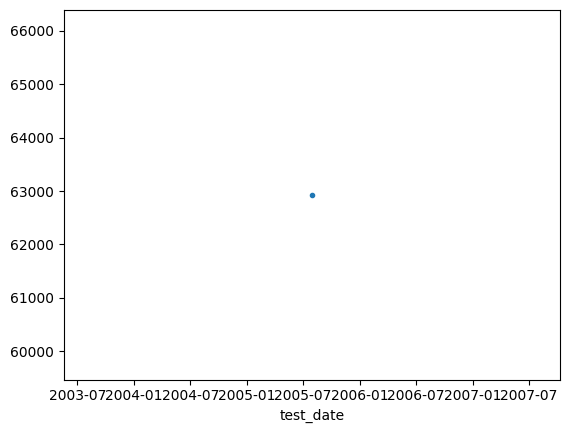

In [22]:
rover_df.set_index('test_date').test_mileage.plot(marker='.')

## Items

In [23]:
item_files_df = csv_info_df[csv_info_df.file.str.contains('item')]
item_files_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
0,data/test_item_2005.txt,\r\n,0,False,|,"""",False
1,data/test_item_2006.txt,\r\n,0,False,|,"""",False
2,data/test_item_2007.txt,\r\n,0,False,|,"""",False
3,data/test_item_2008.txt,\r\n,0,False,|,"""",False
4,data/test_item_2009.txt,\r\n,0,False,|,"""",False
5,data/test_item_2010.txt,\r\n,0,False,|,"""",False
6,data/test_item_2011.txt,\r\n,0,False,|,"""",False
7,data/test_item_2012.txt,\r\n,0,False,|,"""",False
8,data/test_item_2013.txt,\r\n,0,False,|,"""",False
9,data/test_item_2014.txt,\r\n,0,False,|,"""",False


In [24]:
def read_items(file, sep):
    df = dd.read_csv(file,
                     delimiter=sep,
                     dtype={'dangerous_mark': 'string[pyarrow]'},
                     dtype_backend='pyarrow',
                     # engine='pyarrow',
                    )
        
    return df

item_records = item_files_df[['file', 'delimiter']].to_records(index=False)
item_ddfs = [read_items(file, sep) for file, sep in item_records]

In [25]:
item_ddf = dd.concat(item_ddfs[:3])

In [26]:
item_ddf.dtypes

test_id            int64[pyarrow]
rfr_id             int64[pyarrow]
rfr_type_code     string[pyarrow]
location_id        int64[pyarrow]
dangerous_mark    string[pyarrow]
dtype: object

In [27]:
item_ddf.info()
item_ddf.head()

<class 'dask.dataframe.core.DataFrame'>
Columns: 5 entries, test_id to dangerous_mark
dtypes: int64[pyarrow](3), string[pyarrow](1), string(1)

,test_id,rfr_id,rfr_type_code,location_id,dangerous_mark
0,1343771031,8394,A,7,<NA>
1,1560692612,8394,F,13,<NA>
2,1560692612,7977,F,9,<NA>
3,1560692612,7916,A,7,<NA>
4,1560692612,7916,A,9,<NA>


In [28]:
f_item = (
    item_ddf
    .to_parquet('item.parquet', write_index=False, overwrite=True, compute=False)
    .persist()
)

progress(f_item)

VBox()

In [29]:
wait(f_item)
item_ddf = dd.read_parquet('item.parquet')

In [30]:
item_ddf.dtypes

test_id            int64[pyarrow]
rfr_id             int64[pyarrow]
rfr_type_code     string[pyarrow]
location_id        int64[pyarrow]
dangerous_mark     string[python]
dtype: object

In [31]:
rfr_counts = item_ddf.rfr_id.value_counts().compute()

In [32]:
rfr_counts

rfr_id
8394     13359078
8141      5840128
8293      3913996
8483      2954558
8310      2864162
           ...   
9381            1
9392            1
9393            1
9712            1
10009           1
Name: count, Length: 3580, dtype: int64[pyarrow]

## Reasons for rejection (test fail)

Not sure if this includes advisories

In [33]:
rfr_df = dd.read_csv('data/unzipped/dft_item_detail.csv', sep='|', dtype_backend='pyarrow')
rfr_df.info(verbose=True)
rfr_df.head()

<class 'dask.dataframe.core.DataFrame'>
RangeIndex: 20957 entries, 0 to 20956
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   rfr_id                    20957 non-null      int64[pyarrow]
 1   test_class_id             20957 non-null      int64[pyarrow]
 2   test_item_id              20957 non-null      int64[pyarrow]
 3   minor_item                20957 non-null      string[pyarrow]
 4   rfr_desc                  20957 non-null      string[pyarrow]
 5   rfr_loc_marker            20957 non-null      string[pyarrow]
 6   rfr_insp_manual_desc      20799 non-null      string[pyarrow]
 7   rfr_advisory_text         6780 non-null      string[pyarrow]
 8   test_item_set_section_id  20957 non-null      int64[pyarrow]
dtypes: int64[pyarrow](4), string[pyarrow](5)
memory usage: 3.7 MB


,rfr_id,test_class_id,test_item_id,minor_item,rfr_desc,rfr_loc_marker,rfr_insp_manual_desc,rfr_advisory_text,test_item_set_section_id
0,4,1,3,Y,missing,N,an obligatory lamp missing,<NA>,1
1,4,2,3,Y,missing,N,an obligatory lamp missing,<NA>,1
2,5,1,3,Y,damaged and function impaired,N,so damaged or deteriorated that its function i...,damaged but function not impaired,1
3,5,2,3,Y,damaged and function impaired,N,so damaged or deteriorated that its function i...,damaged but function not impaired,1
4,6,1,3,Y,deteriorated and function impaired,N,so damaged or deteriorated that its function i...,deteriorated but function not impaired,1


In [34]:
rfr_df.query('rfr_id == 8394').compute()

,rfr_id,test_class_id,test_item_id,minor_item,rfr_desc,rfr_loc_marker,rfr_insp_manual_desc,rfr_advisory_text,test_item_set_section_id
11001,8394,3,5655,Y,tread depth below requirements of 1.6mm,Y,The grooves of the tread pattern are not at le...,worn close to the legal limit,5650
11002,8394,4,5655,Y,tread depth below requirements of 1.6mm,Y,The grooves of the tread pattern are not at le...,worn close to the legal limit,5650
11003,8394,7,5655,Y,tread depth below requirements of 1.6mm,Y,The grooves of the tread pattern are not at le...,worn close to the legal limit,5650
